In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
def data_load(train_path, test_path):
    df_train = pd.read_csv(train_path)
    df_test = pd.read_csv(test_path)
    print("information of train set:")
    print(df_train)
    print(df_train.info())
    print(df_train.describe())
    print("information of test set:")
    print(df_test)
    print(df_test.info())
    print(df_test.describe())


    #数据可视化和特征缩放
    df_train_scaled = df_train.copy()
    df_test_scaled = df_test.copy()

    #方向数字化
    mapping = {'NE': 0, 'SE': 1, 'NW': 2, 'cv': 3}
    df_train_scaled['wnd_dir'] = df_train_scaled['wnd_dir'].map(mapping)
    df_test_scaled['wnd_dir'] = df_test_scaled['wnd_dir'].map(mapping)

    #时间变成索引形式
    df_train_scaled['date'] = pd.to_datetime(df_train_scaled['date'])
    df_train_scaled.set_index('date', inplace=True)
    df_train_scaled.head()

    values = df_train_scaled.values
    print(df_train_scaled)
    print("\n##################\n")
    print(df_test_scaled)


    # specify columns to plot
    groups = [0, 1, 2, 3, 5, 6, 7]
    i = 1

    # 画出训练集以时间为变量的各指标变化趋势
    plt.figure(figsize=(20,14))
    for group in groups:
        plt.subplot(len(groups), 1, i)
        plt.plot(values[:, group], color=cm.plasma(group/len(groups)))
        plt.xlabel('Index')
        plt.title(df_train.columns[group+1], y=0.75, loc='right', fontsize = 15)
        i += 1
    plt.show()

    # 画出测试集各指标的分布图
    sns.set(style="darkgrid")
    fig, axs = plt.subplots(3,2, figsize=(24,14))
    sns.histplot(data=df_test_scaled, x="pollution", kde=True, color="skyblue", ax=axs[0, 0])
    sns.histplot(data=df_test_scaled, x="dew", kde=True, color="olive", ax=axs[0, 1])
    sns.histplot(data=df_test_scaled, x="temp", kde=True, color="gold", ax=axs[1, 0])
    sns.histplot(data=df_test_scaled, x="press", kde=True, color="teal", ax=axs[1, 1])
    sns.histplot(data=df_test_scaled, x="wnd_dir", kde=True, color="steelblue", ax=axs[2, 0])
    sns.histplot(data=df_test_scaled, x="wnd_spd", kde=True, color="goldenrod", ax=axs[2, 1])
    plt.show()

    # 特征缩放器 归一化
    scaler = MinMaxScaler()

    # 确定训练集以及测试集中要归一化的列
    columns = (['pollution', 'dew', 'temp', 'press', "wnd_dir", 'wnd_spd', 'snow', 'rain'])

    df_test_scaled = df_test_scaled[columns]

    # Scale the selected columns to the range 0-1
    df_train_scaled[columns] = scaler.fit_transform(df_train_scaled[columns])
    df_test_scaled[columns] = scaler.transform(df_test_scaled[columns])

    # Show the scaled data
    print(df_train_scaled.head())
    print(df_test_scaled.head())

    #数据拆分为训练集和测试集 x是dew开始的7个特征，y是pollution
    #一个x是11个时间步长，y是1个时间步长
    df_train_scaled = np.array(df_train_scaled)
    df_test_scaled = np.array(df_test_scaled)

    X = []
    y = []
    n_future = 1
    n_past = 11

    #  Train Sets
    for i in range(n_past, len(df_train_scaled) - n_future+1):
        X.append(df_train_scaled[i - n_past:i, 1:df_train_scaled.shape[1]])
        y.append(df_train_scaled[i + n_future - 1:i + n_future, 0])
    X_train, y_train = np.array(X), np.array(y)

    #  Test Sets
    X = []
    y = []
    for i in range(n_past, len(df_test_scaled) - n_future+1):
        X.append(df_test_scaled[i - n_past:i, 1:df_test_scaled.shape[1]])
        y.append(df_test_scaled[i + n_future - 1:i + n_future, 0])
    X_test, y_test = np.array(X), np.array(y)

    print('X_train shape : {}   y_train shape : {} \n'
          'X_test shape : {}      y_test shape : {} '.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))
    return X_train, y_train, X_test, y_test

In [3]:
def LSTM_model(train_path, test_path, flag):
    X_train, y_train, X_test, y_test = data_load(train_path, test_path)
    if flag == 1:
        #创建一个LSTM模型
        model = Sequential()
        model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(16, return_sequences=False))
        model.add(Dense(y_train.shape[1]))

        # Compile the model
        model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

        # Define callbacks for avoiding overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

        model.summary()
        history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, callbacks=[early_stopping, checkpoint], shuffle=False)

        plt.figure(figsize=(15,6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    # Load the best model
    best_model = load_model('best_model.keras')

    # Make predictions on the test set
    test_predictions = best_model.predict(X_test).flatten()
    test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                      'Actual':y_test.flatten()})
    # 保存到文件，确保列名和数据左对齐
    output = "test_results.txt"
    with open(output, "w") as f:
        # 写入列名
        f.write(f"{'Train Predictions':<20}{'Actual':<20}\n")
        # 写入数据
        for index, row in test_results.iterrows():
            f.write(f"{row['Train Predictions']:<20.6f}{row['Actual']:<20.6f}\n")

    test_results.head()

    plt.plot(test_results['Train Predictions'][:350], label='Predicted Values')
    plt.plot(test_results['Actual'][:350], label='True Values')
    plt.legend()
    plt.show()

    rmse = sqrt(mse(y_test, test_predictions))
    print('Test RMSE: %.5f' % rmse)

information of train set:
                      date  pollution  dew  temp   press wnd_dir  wnd_spd  \
0      2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79   
1      2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68   
2      2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57   
3      2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36   
4      2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25   
...                    ...        ...  ...   ...     ...     ...      ...   
43795  2014-12-31 19:00:00        8.0  -23  -2.0  1034.0      NW   231.97   
43796  2014-12-31 20:00:00       10.0  -22  -3.0  1034.0      NW   237.78   
43797  2014-12-31 21:00:00       10.0  -22  -3.0  1034.0      NW   242.70   
43798  2014-12-31 22:00:00        8.0  -22  -4.0  1034.0      NW   246.72   
43799  2014-12-31 23:00:00       12.0  -21  -3.0  1034.0      NW   249.85   

       snow  rain  
0         0     0  
1        

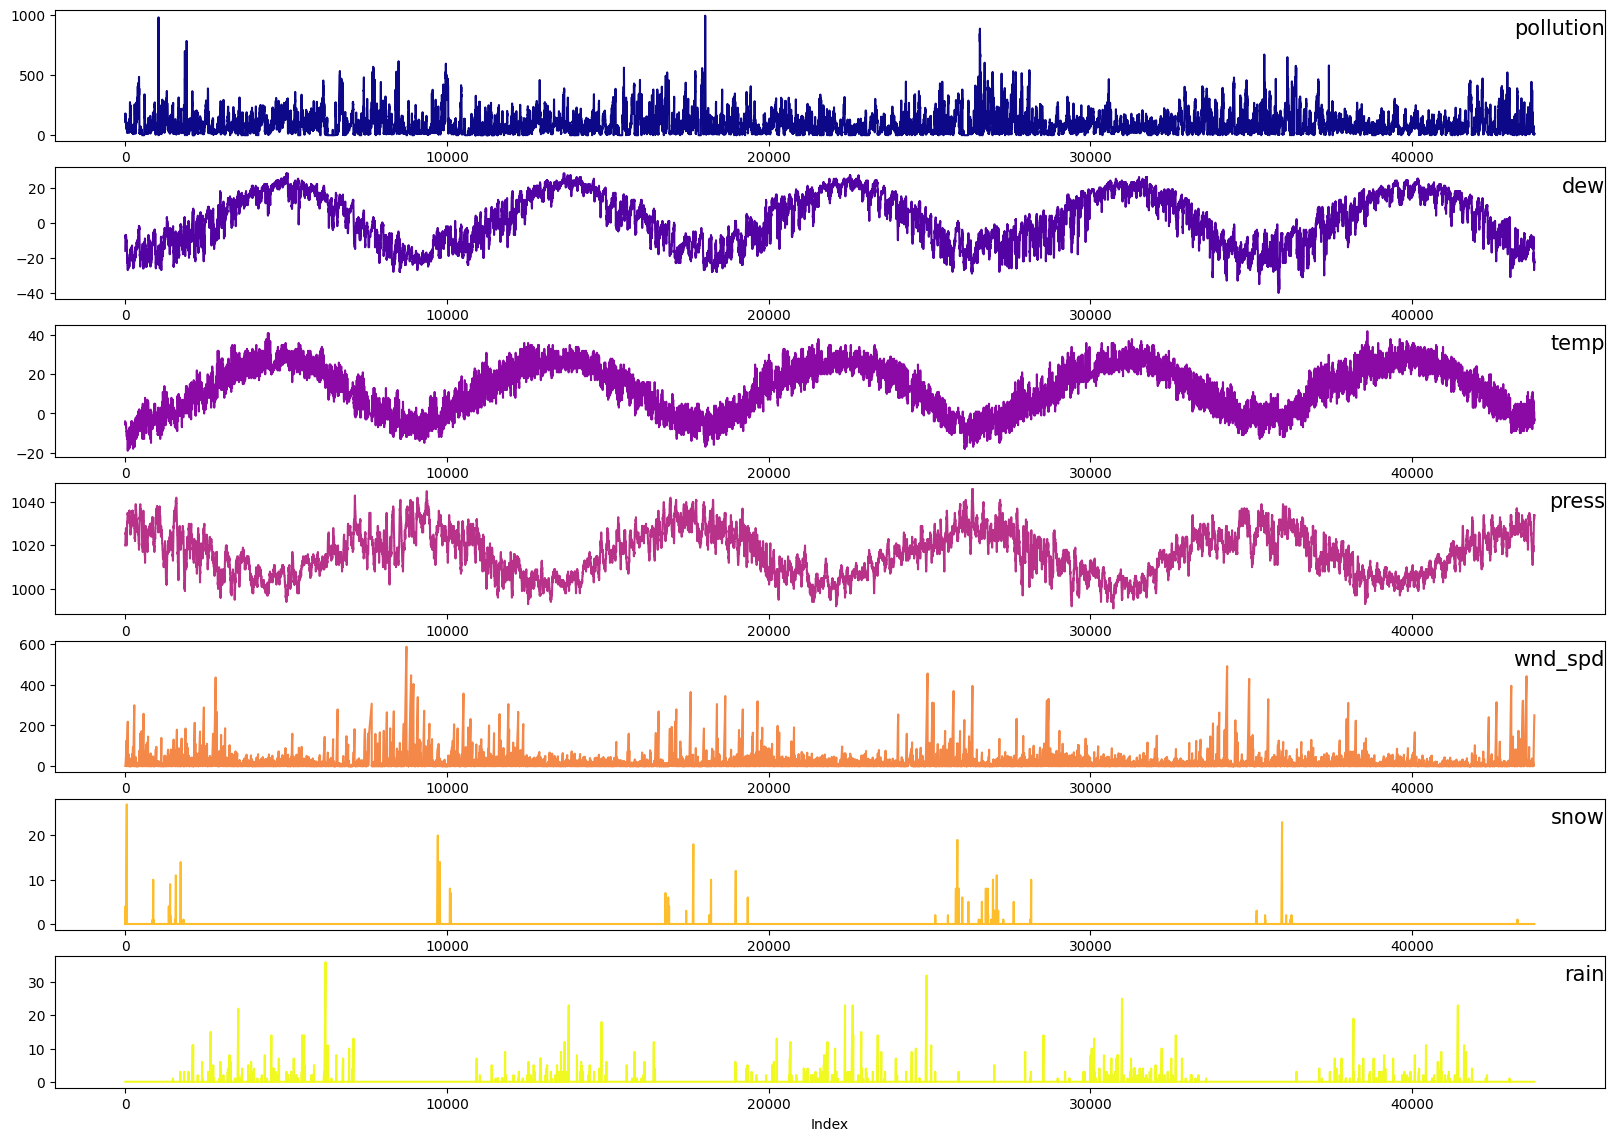

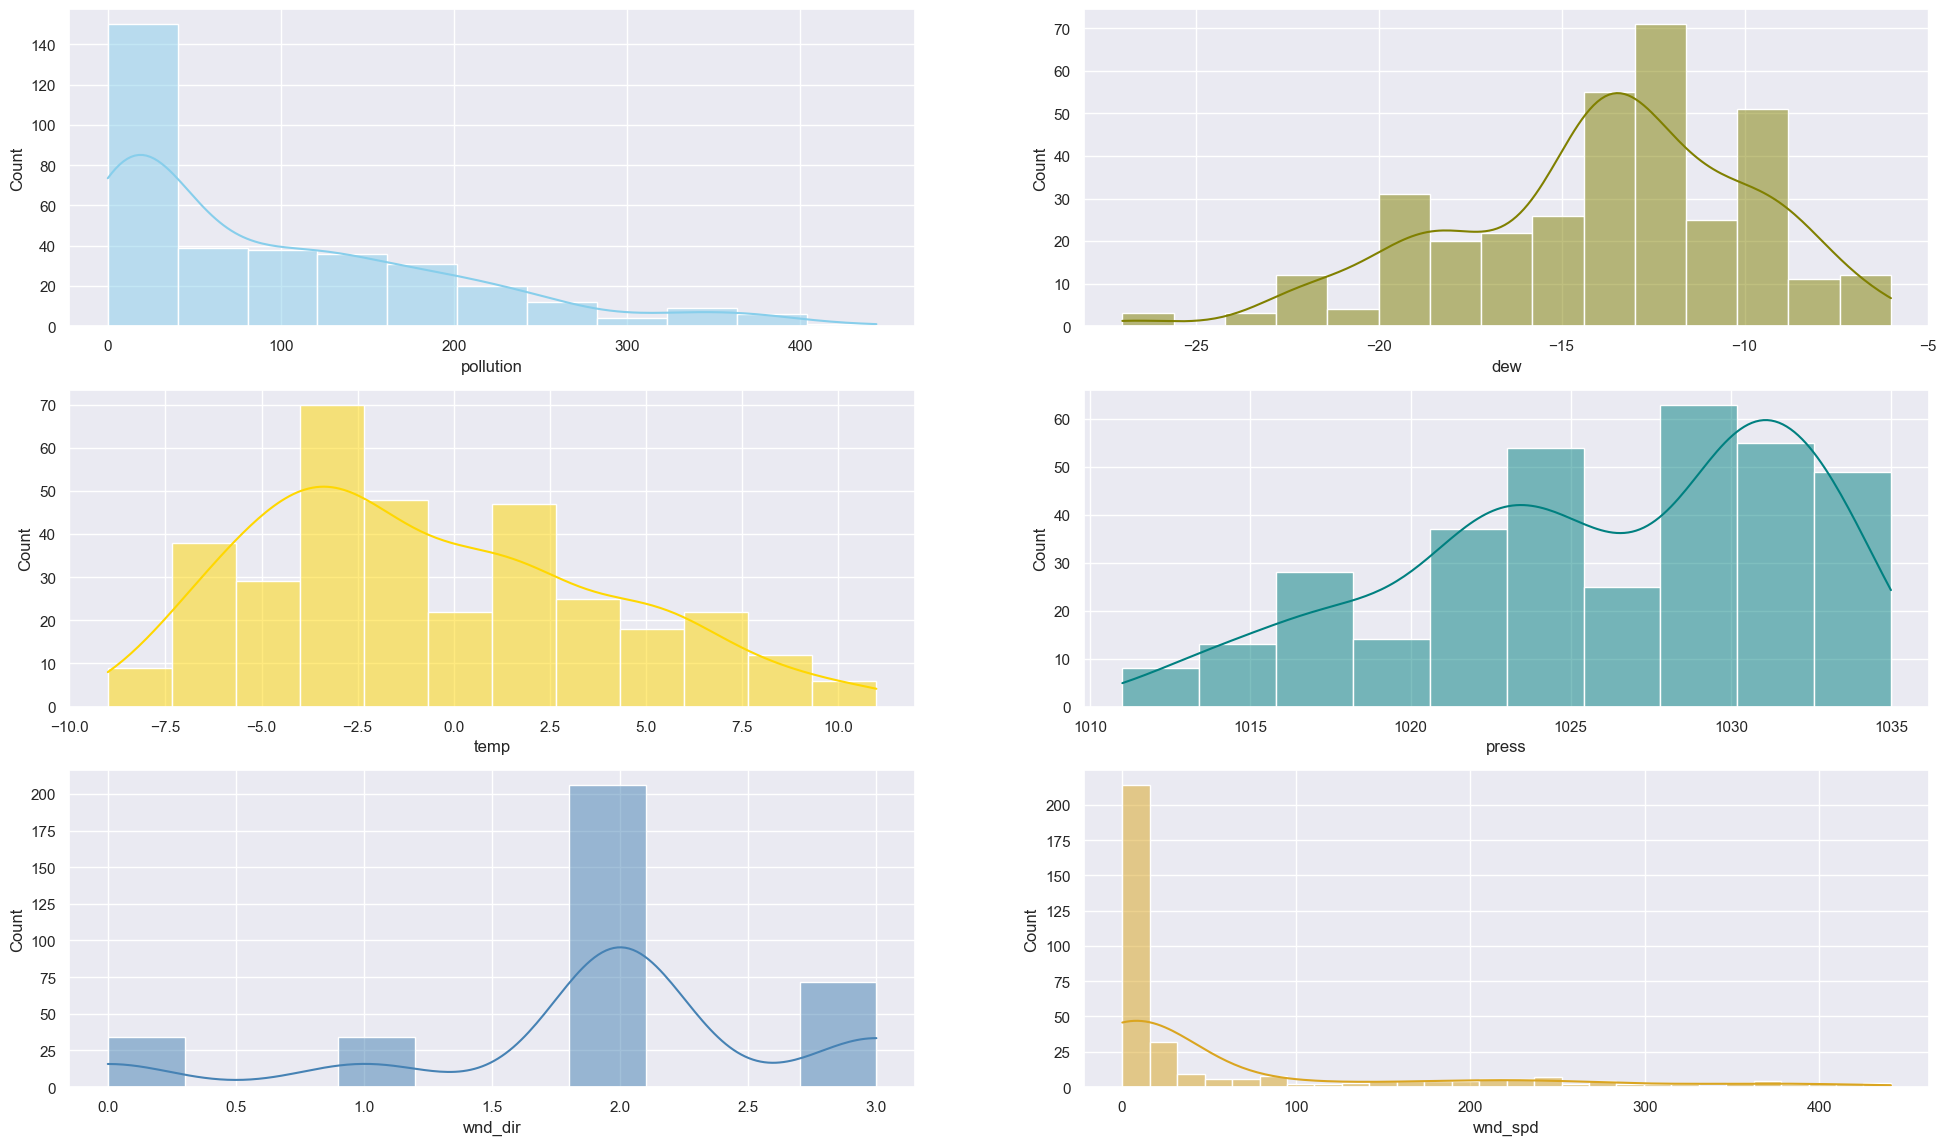

                     pollution       dew      temp     press   wnd_dir  \
date                                                                     
2010-01-02 00:00:00   0.129779  0.352941  0.245902  0.527273  0.333333   
2010-01-02 01:00:00   0.148893  0.367647  0.245902  0.527273  0.333333   
2010-01-02 02:00:00   0.159960  0.426471  0.229508  0.545455  0.333333   
2010-01-02 03:00:00   0.182093  0.485294  0.229508  0.563636  0.333333   
2010-01-02 04:00:00   0.138833  0.485294  0.229508  0.563636  0.333333   

                      wnd_spd      snow  rain  
date                                           
2010-01-02 00:00:00  0.002290  0.000000   0.0  
2010-01-02 01:00:00  0.003811  0.000000   0.0  
2010-01-02 02:00:00  0.005332  0.000000   0.0  
2010-01-02 03:00:00  0.008391  0.037037   0.0  
2010-01-02 04:00:00  0.009912  0.074074   0.0  
   pollution       dew      temp     press   wnd_dir   wnd_spd  snow  rain
0   0.128773  0.352941  0.377049  0.654545  0.333333  0.005349   0.0  

C:\Users\86135\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 11, 32)              │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 11, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,273 (32.32 KB)

 Trainable params: 8,273 (32.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0082 - root_mean_squared_error: 0.0902 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1127
Epoch 2/150
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1116
Epoch 3/150
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0070 - root_mean_squared_error: 0.0835 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1080
Epoch 4/150
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0067 - root_mean_squared_error: 0.0817 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1043
Epoch 5/150
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0065 - root_mean_squared_error: 0.0803 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1026
Epoch 6/150
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0063 - root_mean_squared_error: 0.0795 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1030
Epoch 7/150
1232/1232 

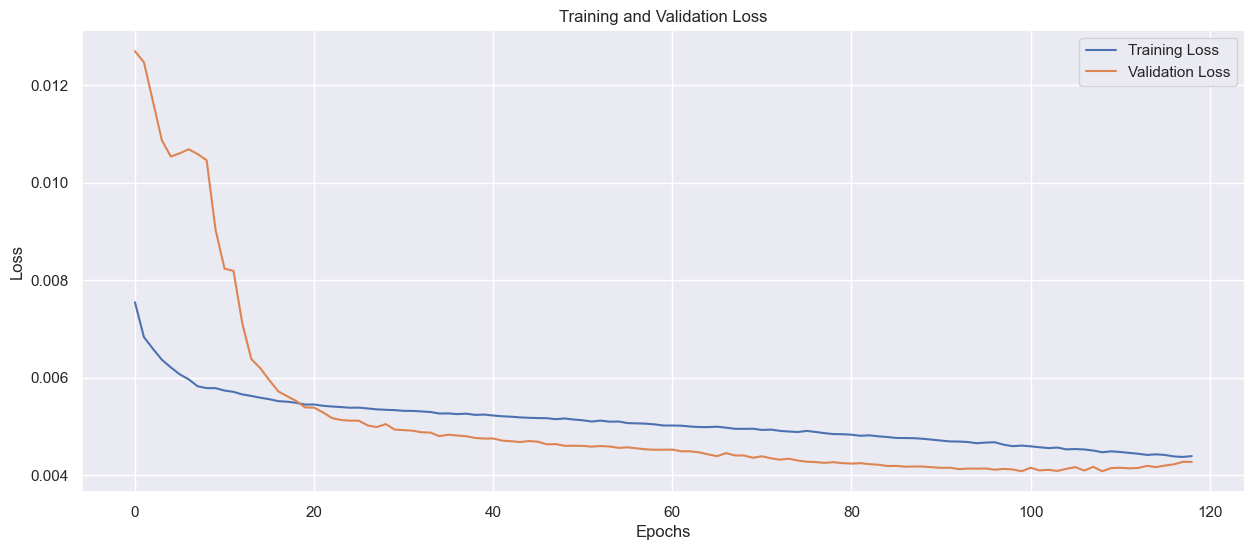

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


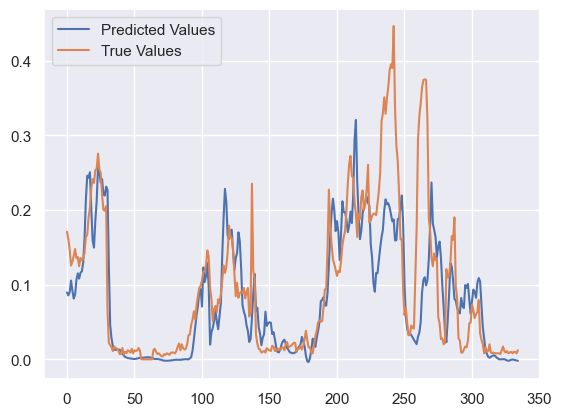

Test RMSE: 0.06757


In [4]:
if __name__ == '__main__':
    # 读取数据集
    train_path = "LSTM-Multivariate_pollution.csv"
    test_path = "pollution_test_data1.csv"

    #flag == 1: 从头训练模型
    #flag == 0: 直接调用训练好的模型来跑测试集
    LSTM_model(train_path, test_path,1)